# Installation

In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
#import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [2]:
tf.version.VERSION

'2.6.0'

# Hyper Parameters

In [3]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

# Environment

Set up the environment and check the rendering.

In [4]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

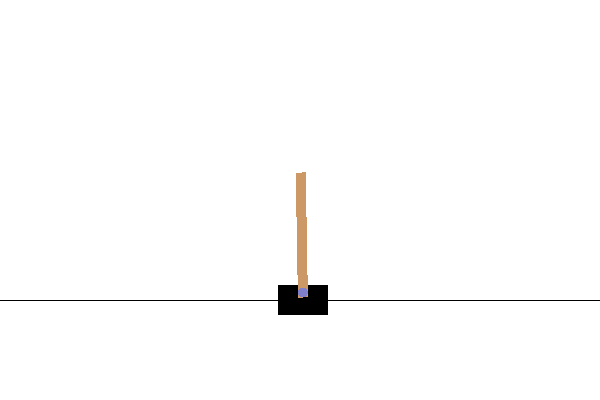

In [5]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

Under this environment:
- `observation` is an array of four float values
    - Position & speed of the cart
    - Angular position & speed of the pole
- `reward` is a scalar float
- `action` is a scalar integer with two possible values
    - 0: move left
    - 1: move right

In [6]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [7]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [8]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [9]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.04888237,  0.04256639, -0.0007839 , -0.00678765], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.04973369,  0.23769957, -0.00091965, -0.2997178 ], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1)})


In [10]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [11]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Agents

For this tutorial, DQN is used.

In [12]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [13]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

# Policy

Plicies define how agents act under an environment.

In this tutorial
- The desired result is that the pole on the cart does not fall off
- The policy returns an action (left or right) every `time_step`

The agent has two policies:
- `agent.policy`: the main policy used for the evaluation and deployment
- `agent.collect_policy`: a supplmental policy for the data collection

In [14]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

A policy can be created irrelevantly to agents.

In [15]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

In [16]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))
time_step = example_environment.reset()
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>, state=(), info=())

# Index and Evaluation

The index most used for policy evaluation is the average return

In [17]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [18]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

25.3

# Replay Buffer

In [19]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [20]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0, dtype=int64), maximum=array(1, dtype=int64)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [21]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

# Data Collection

In [22]:
#@test {"skip": true}
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

In [23]:
iter(replay_buffer.as_dataset()).next()

Instructions for updating:
Use `tf.data.Dataset.scan(...) instead
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


(Trajectory(
 {'action': <tf.Tensor: shape=(), dtype=int64, numpy=0>,
  'discount': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
  'next_step_type': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
  'observation': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.07383236, -0.2397277 ,  0.18367335,  0.85164726], dtype=float32)>,
  'policy_info': (),
  'reward': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
  'step_type': <tf.Tensor: shape=(), dtype=int32, numpy=1>}),
 BufferInfo(ids=<tf.Tensor: shape=(), dtype=int64, numpy=36>, probabilities=<tf.Tensor: shape=(), dtype=float32, numpy=0.01>))

In [24]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(
{action: (64, 2),
 discount: (64, 2),
 next_step_type: (64, 2),
 observation: (64, 2, 4),
 policy_info: (),
 reward: (64, 2),
 step_type: (64, 2)}), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(
{action: tf.int64,
 discount: tf.float32,
 next_step_type: tf.int32,
 observation: tf.float32,
 policy_info: (),
 reward: tf.float32,
 step_type: tf.int32}), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [25]:
iterator = iter(dataset)

print(iterator)

iterator.next()

(Trajectory(
 {'action': <tf.Tensor: shape=(64, 2), dtype=int64, numpy=
 array([[0, 0],
        [0, 0],
        [0, 1],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [1, 0],
        [0, 1],
        [1, 1],
        [0, 0],
        [1, 0],
        [0, 1],
        [1, 1],
        [1, 0],
        [1, 1],
        [1, 1],
        [0, 1],
        [0, 0],
        [1, 0],
        [0, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 0],
        [1, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 0],
        [1, 0],
        [0, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 0],


# Training Agents

In [26]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)
# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 13.336959838867188
step = 400: loss = 21.479015350341797
step = 600: loss = 35.116912841796875
step = 800: loss = 4.410943984985352
step = 1000: loss = 34.771522521972656
step = 1000: Average Return = 21.5
step = 1200: loss = 7.912104606628418
step = 1400: loss = 14.191957473754883
step = 1600: loss = 34.051212310791016
step = 1800: loss = 14.896556854248047
step = 2000: loss = 22.60882568359375
step = 2000: Average Return = 84.69999694824219
step = 2200: loss = 23.473602294921875
step = 2400: loss = 8.234210968017578
step = 2600: loss = 83.88407897949219
step = 2800: loss = 72.32830810546875
step = 3000: loss = 53.363685607910156
step = 3000: Average Return = 73.69999694824219
step = 3200: loss = 133.87899780273438
step = 3400: loss = 8

# Visualization
## Plotting

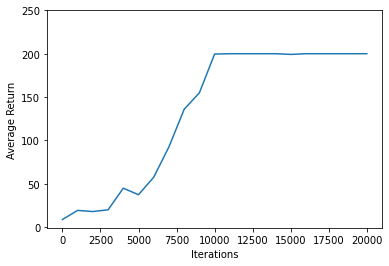

In [29]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)
plt.show()

## Video

In [28]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [29]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [ ]:
create_policy_eval_video(agent.policy, "trained-agent")

In [27]:
create_policy_eval_video(random_policy, "random-agent")

NameError: name 'create_policy_eval_video' is not defined